In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library installed

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import cv2, random
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

##Importing pre-trained model for transfer learning

In [3]:
from tensorflow.keras.applications import VGG19

### This metric creates four local variables, true_positives, true_negatives, false_positives and false_negatives that are used to compute the AUC.
### Here, receiver operating characteristics at default threshold is being used.
### It tells us how much area at the given threshold is the ROC curve covering. Higher the area, better the classifier.

In [4]:
AUC_value = AUC(curve = 'ROC', name = 'auc_value', multi_label = False)


##Global Variables

### If true, concatenate the data
### Desired Image Size
### Input image shape
### Learning rate for training
### Learning rate for fine-tuning



In [5]:
join = True
image_size = 224
i_shape = (image_size, image_size, 3)

lr_cnn = 1e-5
lr_ft = 1e-6

class_names = ['Normal', 'Cataract', 'Glaucoma', 'Myopia']
classes = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']

# Path to full_df.csv

In [6]:
data = pd.read_csv('/content/drive/MyDrive/PROJECT/full_df.csv')


# Displaying the top three rows and all the columns of the dataset

In [7]:
print(data.head(3))

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

        

In [8]:
print(data.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')


In [9]:

print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Path to data.xlsx

In [10]:
DATA_PATH = '/content/drive/MyDrive/ODIR-5K/ODIR-5K/data.xlsx'
main_df = pd.read_excel(DATA_PATH)
sample_in_classes = main_df.iloc[:, -8:]
all_classes = sample_in_classes.sum()
print(all_classes)


N    1140
D    1128
G     215
C     212
A     164
H     103
M     174
O     979
dtype: int64


In [11]:
!pip install opencv-python

## Displaying some random images from the dataset

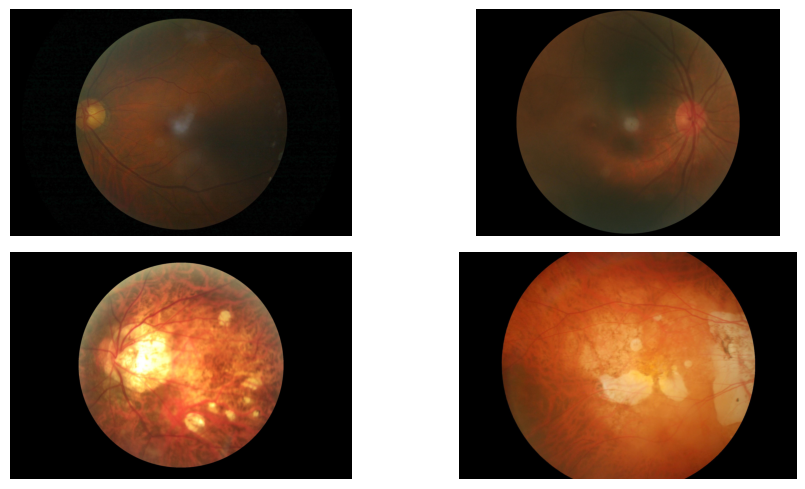

In [12]:

show_images = ['/content/drive/MyDrive/ODIR-5K/ODIR-5K/Training Images/1006_left.jpg', '/content/drive/MyDrive/ODIR-5K/ODIR-5K/Training Images/0_right.jpg', '/content/drive/MyDrive/ODIR-5K/ODIR-5K/Training Images/1537_left.jpg', '/content/drive/MyDrive/ODIR-5K/ODIR-5K/Training Images/1613_right.jpg']
count = 0

plt.figure(figsize = (10, 5))
for iter in show_images:
    im = cv2.imread(iter)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, 1 + count)
    plt.imshow(im)
    plt.axis('off')
    count += 1
plt.tight_layout()



## Visualizing the dataset

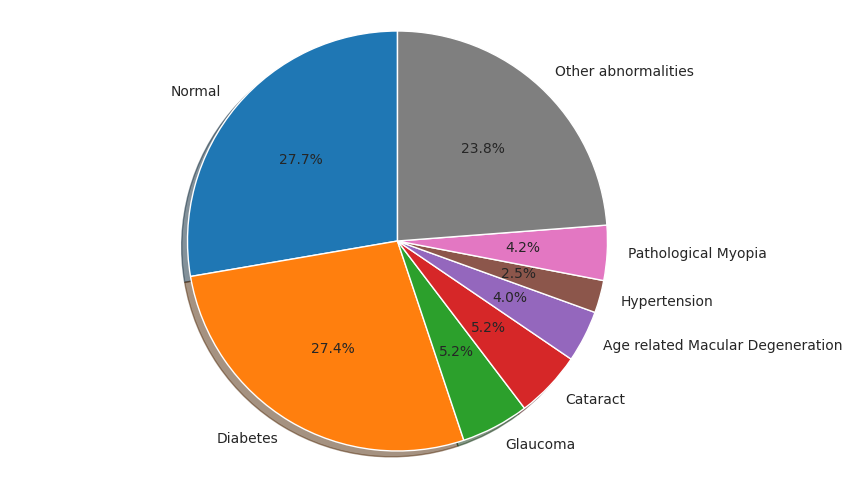

In [13]:

plt.figure(figsize = (10, 6))
plt.pie(all_classes, labels = classes, startangle = 90, autopct='%1.1f%%', shadow = True)
plt.axis('equal')
plt.show()

## Defining a function to find a keyword in the text

In [14]:
def if_keyword(text, keyword):
    if keyword in text:
        return 1
    else:
        return 0

## Finding the keyword in left and right diagnostic keywords.

In [15]:


data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: if_keyword(x, 'cataract'))
data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: if_keyword(x, 'cataract'))

data['left_normal'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'normal fundus'))
data['right_normal'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'normal fundus'))

data['left_glaucoma'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'glaucoma'))
data['right_glaucoma'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'glaucoma'))

data['left_myopia'] = data['Left-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'pathological myopia'))
data['right_myopia'] = data['Right-Diagnostic Keywords'].apply(lambda x: if_keyword(x, 'pathological myopia'))

## Images having 'cataract' associated with their Diagnostic Keywords

In [16]:
left_cataract = data.loc[(data.C == 1) & (data.left_cataract == 1)]["Left-Fundus"].values
right_cataract = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values



## 300-Images having 'normal' associated with their Diagnostic Keywords
##All or more images can be taken into consideration by removing or changing the sample function

In [17]:
left_normal = data.loc[(data.N == 1) & (data.left_normal == 1)]["Left-Fundus"].sample(300, random_state = 11).values
right_normal = data.loc[(data.N == 1) & (data.right_normal == 1)]["Right-Fundus"].sample(300, random_state = 11).values

left_glaucoma = data.loc[(data.G == 1) & (data.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = data.loc[(data.G == 1) & (data.right_glaucoma == 1)]["Right-Fundus"].values

left_myopia = data.loc[(data.M == 1) & (data.left_myopia == 1)]["Left-Fundus"].values
right_myopia = data.loc[(data.M == 1) & (data.right_myopia == 1)]["Right-Fundus"].values

##Joining both the arrays (left eye's and right eye's diagnosys) into one single arrays for each of the classes.

In [18]:
if join:
    cataract = np.concatenate((left_cataract, right_cataract), axis = 0)
    normal = np.concatenate((left_normal, right_normal), axis = 0)
    glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis = 0)
    myopia = np.concatenate((left_myopia, right_myopia), axis = 0)
    join = False

print(f'Cataract: {len(cataract)} \t Normal: {len(normal)} \t Glaucoma: {len(glaucoma)} \t Myopia: {len(myopia)}')

Cataract: 594 	 Normal: 600 	 Glaucoma: 616 	 Myopia: 457


##Visualizing the dataset

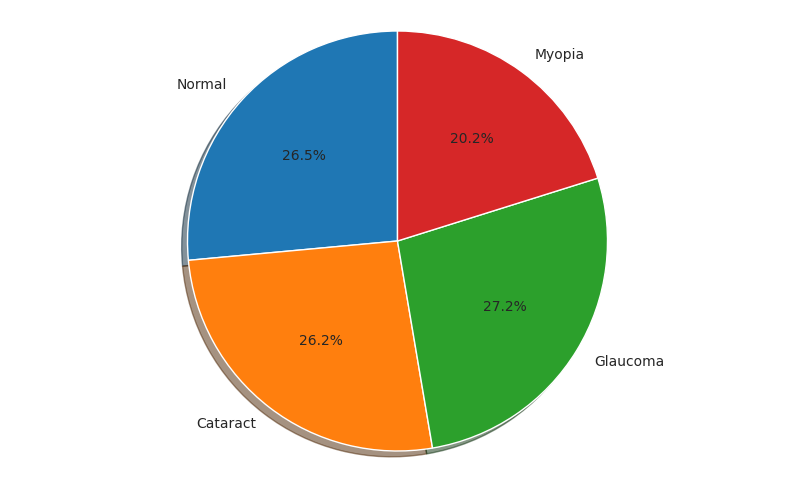

In [19]:
our_classes = [600, 594, 616, 457]
plt.figure(figsize = (10, 6))
plt.pie(our_classes, labels = class_names, startangle = 90, autopct='%1.1f%%', shadow = True)
plt.axis('equal')
plt.show()

In [20]:
def CLAHE(img, clipLimit, tileGridSize):
  clahe = cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)                    # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)                                      # split on 3 different channels
  l2 = clahe.apply(l)                                           # apply CLAHE to the L-channel
  lab = cv2.merge((l2,a,b))                                     # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)                    # convert from LAB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

## Creating one single dataset by combing the images from normal, cataract, glaucoma and myopia diagnosys

In [21]:
dataset_dir = '/content/drive/MyDrive/PROJECT/preprocessed_images'
dataset = []
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        image = CLAHE(image, 20, (10, 10))
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset

In [22]:
import os

In [23]:
data_set1 = create_dataset(normal, 0)
data_set1 = create_dataset(cataract, 1)
data_set1 = create_dataset(glaucoma, 2)
data_set1 = create_dataset(myopia, 3)

100%|██████████| 457/457 [01:04<00:00,  7.05it/s] 


## For Cataract v/s Normal v/s Glaucoma v/s Myopia prediction we have thus created a mini-dataset from the original dataset


In [24]:
print(len(data_set1))

2245


## Displaying randomly selected eight images from the dataset

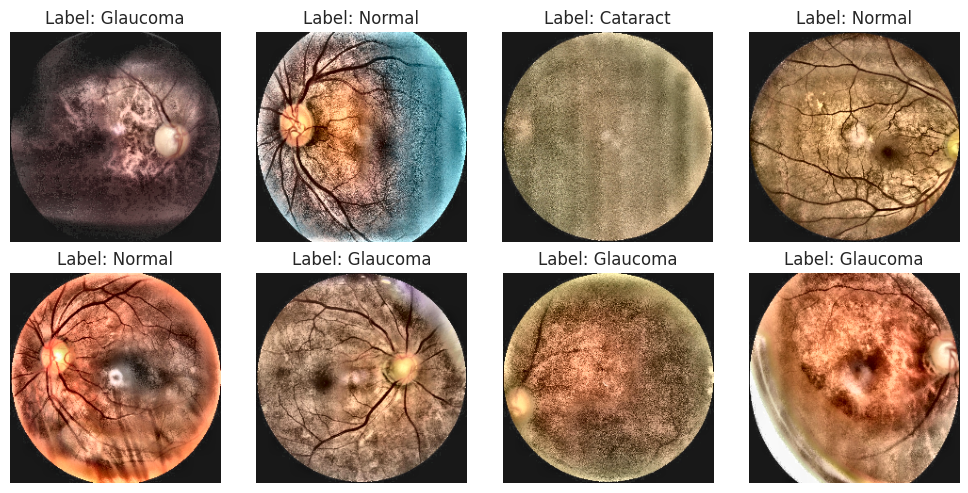

In [25]:
plt.figure(figsize = (10, 5))
for iter in range(8):
    im = random.choice(range(len(dataset)))
    image = dataset[im][0]
    category = dataset[im][1]
    plt.subplot(2, 4, 1 + iter)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Label: %s" %class_names[category])
plt.tight_layout()

## Splitting the dataset into data and associated labels

In [26]:
x_dev = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y_dev = np.array([i[1] for i in dataset])

##Shuffling the samples

In [27]:
indexes = np.arange(x_dev.shape[0])
np.random.shuffle(indexes)
X_dev = x_dev[indexes,:]
Y_dev = y_dev[indexes]

## Then, we split our data into train/val/test sets

In [28]:
train_split = np.int(0.6 * Y_dev.size)
val_split = np.int(0.9 * Y_dev.size)

<ipython-input-28-b3a7b3fe690d>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_split = np.int(0.6 * Y_dev.size)
<ipython-input-28-b3a7b3fe690d>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; f

## 60% of the data for training

In [29]:
X_train = X_dev[: train_split, : ]
Y_train = Y_dev[: train_split]

## 30% for validation

In [30]:
X_val = X_dev[train_split : val_split, : ]
Y_val = Y_dev[train_split : val_split]

## 10% for testing

In [31]:
X_test = X_dev[val_split: , :]
Y_test = Y_dev[val_split : ]

In [32]:
print(f'X_train: {X_train.shape} \tX_val: {X_val.shape} \tX_test: {X_test.shape}')

X_train: (1347, 224, 224, 3) 	X_val: (673, 224, 224, 3) 	X_test: (225, 224, 224, 3)


## Min-Max Normalization

In [33]:
Train_min = X_train.min()
Train_max = X_train.max()

X_train = (X_train - Train_min)/(Train_max - Train_min)
X_val = (X_val - Train_min)/(Train_max - Train_min)
X_test = (X_test - Train_min)/(Train_max - Train_min)

## Representing the labels as one-hot encoded

In [34]:
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)
Y_test_oh = to_categorical(Y_test)

print(f'Labels: {Y_train[:2]}')
print(f'One hot encoded labels: \n{Y_train_oh[:2]}' )

Labels: [0 2]
One hot encoded labels: 
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]]


###Data Augmentation is used to feed the model with minor changes. This technique is very useful when
###we have a dataset which is very imbalannced and/or small in size.
###Here, we are using techniques such as rotating the images by 15 degrees in a random fashion, flipping the images horizontally.
###At a time, a batch of 10 images are fed.

In [35]:
batch_size = 10
gen_params = {"rotation_range":15, "horizontal_flip":True, "fill_mode":'constant', 'cval':0 }
train_gen = ImageDataGenerator(**gen_params)
val_gen = ImageDataGenerator(**gen_params)

train_gen.fit(X_train, seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train, Y_train_oh, batch_size = batch_size)
val_flow = val_gen.flow(X_val, Y_val_oh, batch_size = batch_size)

## The keras ImageDataGenerator returns a generator and thus we have to use getitem().

Minimum pixel value: 0.0 	 Maximum pixel value: 1.0


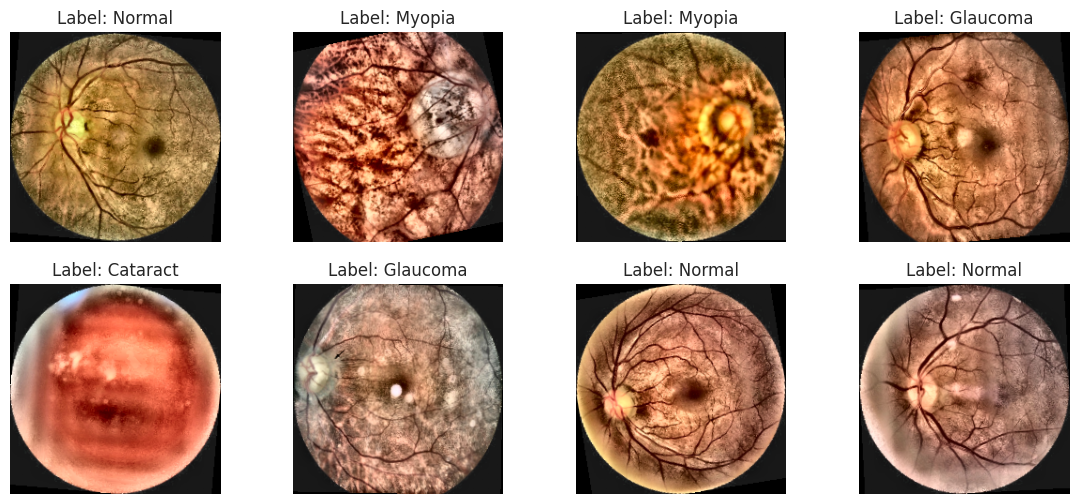

In [36]:
plt.figure(figsize = (14, 6))
X_batch, Y_batch = train_flow.__getitem__(0)
print(f'Minimum pixel value: {X_batch.min()} \t Maximum pixel value: {X_batch.max()}')
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_batch[i])
    plt.title("Label: %s" %class_names[int(Y_batch[i].argmax())])
    plt.axis('off')
plt.show()

In [37]:
def vgg_model(train_l = False, lr = lr_cnn):


    vgg = VGG19(weights = "imagenet", include_top = False, input_shape = (image_size, image_size, 3))

    vgg.trainable = train_l
    input_image = Input(shape = i_shape)
    x1 = vgg(input_image, training = False)
    x2 = Flatten()(x1)
    x3 = Dense(256, activation = 'relu')
    out = Dense(4, activation = 'softmax')(x2)

    vgg_model = Model(inputs = input_image, outputs = out)
    vgg_model.compile(optimizer = Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])
    return vgg_model

In [38]:
model = vgg_model()
print(model)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 100,356
Non-trainable params: 20,024,384
_________________________________________________________________


## Path to save and load the vgg19 model at.

In [39]:
model_name = '/content/drive/MyDrive/ODIR-5K/vgg19.h5'

####These callbacks monitor the training. From changing the learing rate throughout the training process to stopping the training if the validation loss starts increasing, everything is being controlled by these callbacks.
####Here, we save the best model at the path specified by the variable 'model_name'. This saved model can be later directly used without training for the classifying 4 classes.

In [40]:
model_checkpoint = ModelCheckpoint(model_name, monitor = 'val_loss', save_best_only = True, save_weights_only = False, mode = 'min')
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 5, min_delta = 0.0001)

def scheduler(epoch, lr):
    if (epoch + 1) % 5 == 0 and epoch < 20:
        lr /= 2
    elif (epoch + 1) % 15 == 0:
        lr /= 2
    return lr

lr_schedule = LearningRateScheduler(scheduler, verbose = 1)

## This cell starts the training of the model and saves the statistics during the training to the variable 'history'.

In [41]:
history = model.fit(train_flow, batch_size = 10, epochs = 10, validation_data = (val_flow), verbose = 1, callbacks = [lr_schedule, model_checkpoint, early_stop])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/10
135/135 [==============================] - 52s 292ms/step - loss: 1.2771 - accuracy: 0.4439 - precision: 1.0000 - recall: 0.0178 - auc_value: 0.6939 - val_loss: 1.1267 - val_accuracy: 0.5736 - val_precision: 0.9726 - val_recall: 0.1055 - val_auc_value: 0.8257 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/10
135/135 [==============================] - 30s 221ms/step - loss: 1.0438 - accuracy: 0.6281 - precision: 0.9398 - recall: 0.1737 - auc_value: 0.8657 - val_loss: 0.9588 - val_accuracy: 0.6761 - val_precision: 0.9255 - val_recall: 0.2585 - val_auc_value: 0.8926 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/10
135/135 [==============================] - 31s 227ms/step - loss: 0.9021 - accuracy: 0.7313 - precision: 0.9041 - recall: 0.3148 - auc_value: 0.9089 - val_loss: 0.8516 - val

In [42]:
model = load_model('/content/drive/MyDrive/ODIR-5K/vgg19.h5')

model.trainable = True
model.compile(optimizer = Adam(learning_rate = lr_ft), loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC_value])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 20,124,740
Trainable params: 20,124,740
Non-trainable params: 0
_________________________________________________________________


## Same callbacks are used for fine-tuning as well, so as to stop the model from over-fitting.

In [ ]:
tune_history = model.fit(train_flow, batch_size = 10, epochs = 10, validation_data = (val_flow), verbose = 1, callbacks = [lr_schedule, model_checkpoint, early_stop])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 1/10
135/135 [==============================] - 60s 352ms/step - loss: 0.6261 - accuracy: 0.7721 - precision_1: 0.8350 - recall_1: 0.6837 - auc_value: 0.9340 - val_loss: 0.6274 - val_accuracy: 0.7489 - val_precision_1: 0.7851 - val_recall_1: 0.7058 - val_auc_value: 0.9325 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 2/10
135/135 [==============================] - 45s 330ms/step - loss: 0.5470 - accuracy: 0.7921 - precision_1: 0.8346 - recall_1: 0.7379 - auc_value: 0.9500 - val_loss: 0.5863 - val_accuracy: 0.7756 - val_precision_1: 0.8056 - val_recall_1: 0.7325 - val_auc_value: 0.9403 - lr: 1.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 3/10
135/135 [==============================] - 46s 343ms/step - loss: 0.4927 - accuracy: 0.8174 - precision_1: 0.8442 - recall_1: 0.7803 - auc_value: 0.9591 - va

In [ ]:
model.load_weights(model_name)
Y_pred = model.predict(X_test)
Y_pred = Y_pred.argmax(axis = 1)

loss, accuracy, auc, precision, recall = model.evaluate(X_test, Y_test_oh, verbose = 0)
print(f'loss: {loss} \tAccuracy: {accuracy} \tAUC_value: {auc} \tPrecision: {precision} \tRecall: {recall}')

## Here, F1 score is calculated on the predicted values.

In [ ]:
F1_score = f1_score(y_true = Y_test, y_pred = Y_pred, average = 'weighted')

print(f'F1 score: {F1_score}')

In [ ]:
classes=['N', 'C', 'G', 'M']
true_classes = Y_test
print('Confusion Matrix')
cm = confusion_matrix(true_classes, Y_pred)

def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap= 'Blues'):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 30)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",  color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes)

# True positive (TP): correct positive prediction
# False positive (FP): incorrect positive prediction
# True negative (TN): correct negative prediction
# False negative (FN): incorrect negative prediction

# Calculating the error rates: TPR, TNR, FPR

In [ ]:
def calculate_tpr_tnr_fpr(y_test, y_pred_test):
    actual_pos = y_test == 1
    actual_neg = y_test == 0

    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)

    tpr = np.sum(true_pos) / np.sum(actual_pos)
    tnr = np.sum(true_neg) / np.sum(actual_neg)
    fpr = np.sum(false_pos) / np.sum(actual_neg)

    return tpr, tnr, fpr

tpr, tnr, fpr = calculate_tpr_tnr_fpr(Y_test, Y_pred)
print(f'True postive rate, Sensitivity: {tpr}')
print(f'True negative rate, Specitivity: {tnr}')
print(f'False positive rate: {fpr}')

In [ ]:
# Plotting the graphs for accuracy, loss, auc_value, precision, recall v/s epochs

plt.figure(figsize = (20, 15))
epochs = np.arange(len(history.history["accuracy"]))

# accuracy v/s epochs
plt.subplot(3, 2, 1)
plt.plot(epochs, history.history["accuracy"])
plt.plot(epochs, history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.ylim(0, 1)

# loss v/s epochs
plt.subplot(3, 2, 2)
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

# auc_value v/s epochs
plt.subplot(3, 2, 3)
plt.plot(epochs, history.history["auc_value"])
plt.plot(epochs, history.history["val_auc_value"])
plt.title("ROC_AUC_Value")
plt.xlabel("Epochs")
plt.ylabel("AUC_Value")
plt.legend(["Train", "Val"])

# precision v/s epochs
plt.subplot(3, 2, 4)
plt.plot(epochs, history.history["precision"])
plt.plot(epochs, history.history["val_precision"])
plt.title("Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["Train", "Val"])

# recall v/s epochs
plt.subplot(3, 2, 5)
plt.plot(epochs, history.history["recall"])
plt.plot(epochs, history.history["val_recall"])
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["Train", "Val"])
plt.show()

## Plotting 8 random images which were classified wrongly

In [ ]:
wrong_indexes = np.where(Y_pred != Y_test)[0]
print(f'Number of test images: {Y_test.size}')
print(f'Number of wrong predictions: {wrong_indexes.size}')

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int), size = 8, replace = False)
plt.figure(figsize = (10, 5))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(2, 4 , ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title(f"Label: {class_names[Y_test[wrong_indexes[jj]]]} \n Predicted: {class_names[Y_pred[wrong_indexes[jj]]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Plotting 8 random images which were classified rightly

In [ ]:
right_indexes = np.where(Y_pred == Y_test)[0]
print(f'Number of test images: {Y_test.size}')
print(f'Number of right predictions: {right_indexes.size}')

sample_indexes = np.random.choice(np.arange(right_indexes.shape[0], dtype = int), size = 8, replace = False)
plt.figure(figsize = (10, 5))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(2, 4 , ii+1)
    plt.imshow(X_test[right_indexes[jj]], cmap = "gray")
    plt.title(f"Label: {class_names[Y_test[right_indexes[jj]]]} \n Predicted: {class_names[Y_pred[right_indexes[jj]]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()